In [3]:
import tensorflow as tf
import numpy as np
from tqdm import tqdm
from collections import defaultdict
import pickle
from sklearn import datasets

import matplotlib.pyplot as plt
import seaborn as sns

# This notebook niche
import keras.backend as K
import heapq

In [28]:
def sample(n=2000, dim=2, noise=0.3, seed=None):
    np.random.seed(seed)
    # More noise in the moons makes the task harder
    X, y = datasets.make_moons(n_samples=n, shuffle=True, noise=noise)

    # Rescale and shift the dataset to better fit into zero-one box
    X = (X + 1.6) / 4
    X[:, 0] = X[:, 0] - 0.035
    X[:, 1] = (X[:, 1] - 0.17) * 1.75
    # y = tf.one_hot(y, depth=2)
    
    return X, y

X_train, y_train = sample(2000, noise=0.1, seed=1)
X_test, y_test = sample(2000, noise=0.1, seed=2)

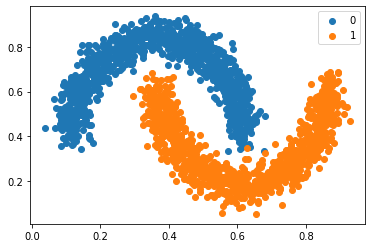

In [29]:
for label in np.unique(y_train):
    idx = np.where(y_train == label)[0]
    plt.scatter(X_train[idx, 0], X_train[idx, 1], label=label)
plt.legend()
plt.show()

In [238]:
def brute_predict(model, X):
    """ Otherwise, predict doesn't work with modified activations """
    for layer in model.layers:
        X = layer(X)
    return X.numpy()

def model2internal_rep(model, X):
    internal_rep = []
    act = X
    for layer in model.layers[:-1]:
        act = layer(act)
        internal_rep.append(act != 0)
    internal_rep = np.hstack(internal_rep).astype(int)
    return internal_rep

def plot_decision_boundaries(model, X, y, xlim=None, ylim=None, n_pts=100, title=None, save_path=None):
    fig, ax = plt.subplots(1, 1, figsize=(8, 5))
    ax.scatter(*list(zip(*X)), c=y, cmap='RdBu', alpha=0.25)

    # plot the decision function
    if xlim is None:
        xlim = ax.get_xlim()
    if ylim is None:
        ylim = ax.get_ylim()

    # create grid to evaluate model
    xx = np.linspace(xlim[0]-0.5, xlim[1]+0.5, n_pts)
    yy = np.linspace(ylim[0]-0.5, ylim[1]+0.5, n_pts)
    YY, XX = np.meshgrid(yy, xx)
    XY = np.vstack([XX.ravel(), YY.ravel()]).T

    # plot linear region boundaries
    # activations = polytope_membership(model, XY)
    colors = ['red', 'blue', 'black']
    internal_rep = model2internal_rep(model, XY)

    for relu_i in range(internal_rep.shape[1]):
        # Z = np.unique(internal_rep, axis=0, return_inverse=True)[1].reshape(XX.shape)
        Z = internal_rep[:, relu_i].reshape(XX.shape)
        CS = plt.contour(XX, YY, Z, colors=colors[0], alpha=1)
    CS.collections[0].set_label('ReLU hyperplanes')
    
    predictions = np.argmax(brute_predict(model, XY), axis=1)
    Z_pred = predictions.reshape(XX.shape)
    CS = plt.contour(XX, YY, Z_pred, colors='black', alpha=1, linestyles='--')
    CS.collections[0].set_label('Softmax decision')

    plt.legend(loc='upper left', bbox_to_anchor=(1.03, 1.02))
    if title is not None:
        plt.title(title)
    plt.tight_layout()
    if save_path is not None:
        plt.savefig(save_path)
    plt.show()

In [168]:
# To remove relu by deleting output
class CustomConnected(tf.keras.layers.Dense):
    def __init__(self, units, connections=None, activations=None, **kwargs):

        #this is matrix A
        self.connections = connections  
        if activations is not None and type(activations) is not list:
            if type(activations) == str:
                self.activations = [tf.keras.activations.get(activations)] * units
            else:
                self.activations = [activations] * units
        else:
            self.activations = activations

        #initalize the original Dense with all the usual arguments   
        super(CustomConnected,self).__init__(units,**kwargs)  

    def call(self, inputs):
        output = K.dot(inputs, self.kernel)
        if self.use_bias:
            output = K.bias_add(output, self.bias)
        if self.activations is not None:
            slices = tf.unstack(output, axis=1)
            activated = []
            for s, act in zip(slices, self.activations):
                activated.append(act(s))
            output = tf.stack(activated, axis=1)
        elif self.activation is not None:
            output = self.activation(output)
        
        if self.connections is not None:
            output = tf.matmul(output, self.connections)
        
        return output
    
def zero_activation(X):
    return X*0

In [135]:
optimizer = tf.keras.optimizers.Adam(0.01)
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)
metric = tf.keras.metrics.SparseCategoricalAccuracy()

Fit model on training data, n_epochs 1
63/63 [==============================] - 1s 5ms/step - loss: 0.5228 - sparse_categorical_accuracy: 0.9180 - val_loss: 0.2798 - val_sparse_categorical_accuracy: 0.8765


<ipython-input-138-5d72315c9957>:34: UserWarning: No contour levels were found within the data range.
  CS = plt.contour(XX, YY, Z, colors=colors[0], alpha=1)


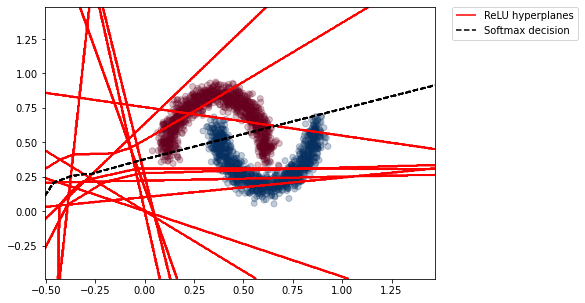

Fit model on training data, n_epochs 5
Epoch 1/5
63/63 [==============================] - 1s 5ms/step - loss: 0.4428 - sparse_categorical_accuracy: 0.8603 - val_loss: 0.2873 - val_sparse_categorical_accuracy: 0.8735
Epoch 2/5
63/63 [==============================] - 0s 3ms/step - loss: 0.2968 - sparse_categorical_accuracy: 0.8561 - val_loss: 0.2644 - val_sparse_categorical_accuracy: 0.8795
Epoch 3/5
63/63 [==============================] - 0s 2ms/step - loss: 0.2520 - sparse_categorical_accuracy: 0.8874 - val_loss: 0.2634 - val_sparse_categorical_accuracy: 0.8805
Epoch 4/5
63/63 [==============================] - 0s 2ms/step - loss: 0.2804 - sparse_categorical_accuracy: 0.8651 - val_loss: 0.2624 - val_sparse_categorical_accuracy: 0.8810
Epoch 5/5
63/63 [==============================] - 0s 2ms/step - loss: 0.2485 - sparse_categorical_accuracy: 0.8814 - val_loss: 0.2618 - val_sparse_categorical_accuracy: 0.8785


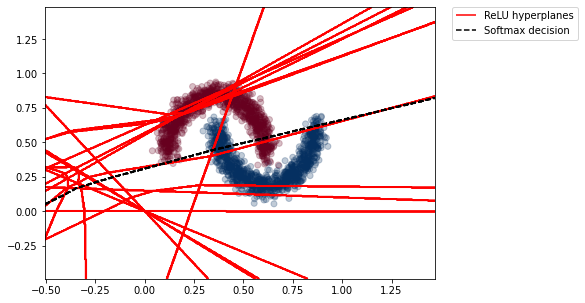

Fit model on training data, n_epochs 10
Epoch 1/10
63/63 [==============================] - 1s 5ms/step - loss: 0.5578 - sparse_categorical_accuracy: 0.8168 - val_loss: 0.2726 - val_sparse_categorical_accuracy: 0.8680
Epoch 2/10
63/63 [==============================] - 0s 3ms/step - loss: 0.2680 - sparse_categorical_accuracy: 0.8697 - val_loss: 0.2606 - val_sparse_categorical_accuracy: 0.8810
Epoch 3/10
63/63 [==============================] - 0s 2ms/step - loss: 0.2498 - sparse_categorical_accuracy: 0.8897 - val_loss: 0.2500 - val_sparse_categorical_accuracy: 0.8830
Epoch 4/10
63/63 [==============================] - 0s 2ms/step - loss: 0.2478 - sparse_categorical_accuracy: 0.8875 - val_loss: 0.3068 - val_sparse_categorical_accuracy: 0.8590
Epoch 5/10
63/63 [==============================] - 0s 2ms/step - loss: 0.3010 - sparse_categorical_accuracy: 0.8600 - val_loss: 0.2549 - val_sparse_categorical_accuracy: 0.8855
Epoch 6/10
63/63 [==============================] - 0s 2ms/step - loss

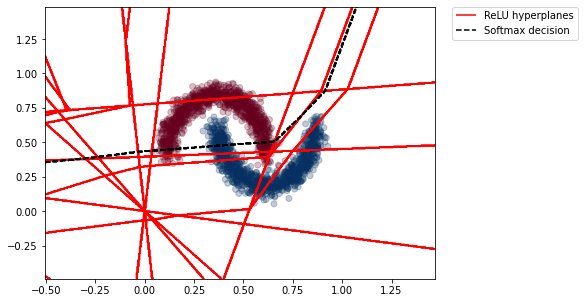

Fit model on training data, n_epochs 25
Epoch 1/25
63/63 [==============================] - 1s 5ms/step - loss: 0.3991 - sparse_categorical_accuracy: 0.8698 - val_loss: 0.2724 - val_sparse_categorical_accuracy: 0.8780
Epoch 2/25
63/63 [==============================] - 0s 3ms/step - loss: 0.2637 - sparse_categorical_accuracy: 0.8687 - val_loss: 0.2649 - val_sparse_categorical_accuracy: 0.8780
Epoch 3/25
63/63 [==============================] - 0s 2ms/step - loss: 0.2545 - sparse_categorical_accuracy: 0.8788 - val_loss: 0.2627 - val_sparse_categorical_accuracy: 0.8790
Epoch 4/25
63/63 [==============================] - 0s 2ms/step - loss: 0.2504 - sparse_categorical_accuracy: 0.8881 - val_loss: 0.2763 - val_sparse_categorical_accuracy: 0.8745
Epoch 5/25
63/63 [==============================] - 0s 2ms/step - loss: 0.2457 - sparse_categorical_accuracy: 0.8946 - val_loss: 0.2625 - val_sparse_categorical_accuracy: 0.8790
Epoch 6/25
63/63 [==============================] - 0s 2ms/step - loss

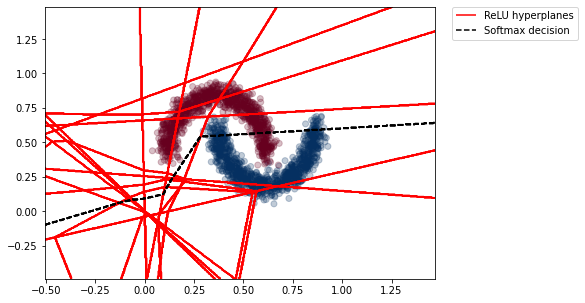

Fit model on training data, n_epochs 50
Epoch 1/50
63/63 [==============================] - 1s 5ms/step - loss: 0.4314 - sparse_categorical_accuracy: 0.8665 - val_loss: 0.2737 - val_sparse_categorical_accuracy: 0.8785
Epoch 2/50
63/63 [==============================] - 0s 3ms/step - loss: 0.2630 - sparse_categorical_accuracy: 0.8858 - val_loss: 0.2800 - val_sparse_categorical_accuracy: 0.8755
Epoch 3/50
63/63 [==============================] - 0s 3ms/step - loss: 0.2733 - sparse_categorical_accuracy: 0.8851 - val_loss: 0.2646 - val_sparse_categorical_accuracy: 0.8800
Epoch 4/50
63/63 [==============================] - 0s 2ms/step - loss: 0.2730 - sparse_categorical_accuracy: 0.8711 - val_loss: 0.2679 - val_sparse_categorical_accuracy: 0.8775
Epoch 5/50
63/63 [==============================] - 0s 2ms/step - loss: 0.2644 - sparse_categorical_accuracy: 0.8779 - val_loss: 0.2624 - val_sparse_categorical_accuracy: 0.8805
Epoch 6/50
63/63 [==============================] - 0s 2ms/step - loss

63/63 [==============================] - 0s 2ms/step - loss: 0.0121 - sparse_categorical_accuracy: 0.9970 - val_loss: 0.0162 - val_sparse_categorical_accuracy: 0.9965
Epoch 47/50
63/63 [==============================] - 0s 2ms/step - loss: 0.0105 - sparse_categorical_accuracy: 0.9948 - val_loss: 0.0155 - val_sparse_categorical_accuracy: 0.9955
Epoch 48/50
63/63 [==============================] - 0s 2ms/step - loss: 0.0097 - sparse_categorical_accuracy: 0.9979 - val_loss: 0.0235 - val_sparse_categorical_accuracy: 0.9915
Epoch 49/50
63/63 [==============================] - 0s 2ms/step - loss: 0.0175 - sparse_categorical_accuracy: 0.9939 - val_loss: 0.0135 - val_sparse_categorical_accuracy: 0.9970
Epoch 50/50
63/63 [==============================] - 0s 2ms/step - loss: 0.0105 - sparse_categorical_accuracy: 0.9963 - val_loss: 0.0132 - val_sparse_categorical_accuracy: 0.9975


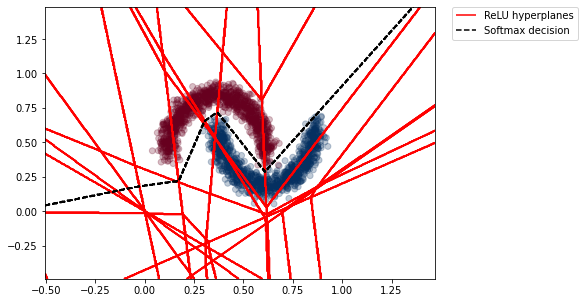

Fit model on training data, n_epochs 100
Epoch 1/100
63/63 [==============================] - 1s 5ms/step - loss: 0.4104 - sparse_categorical_accuracy: 0.9396 - val_loss: 0.2675 - val_sparse_categorical_accuracy: 0.8805
Epoch 2/100
63/63 [==============================] - 0s 3ms/step - loss: 0.2620 - sparse_categorical_accuracy: 0.8784 - val_loss: 0.2643 - val_sparse_categorical_accuracy: 0.8775
Epoch 3/100
63/63 [==============================] - 0s 2ms/step - loss: 0.2589 - sparse_categorical_accuracy: 0.8665 - val_loss: 0.2678 - val_sparse_categorical_accuracy: 0.8785
Epoch 4/100
63/63 [==============================] - 0s 2ms/step - loss: 0.2668 - sparse_categorical_accuracy: 0.8770 - val_loss: 0.2971 - val_sparse_categorical_accuracy: 0.8630
Epoch 5/100
63/63 [==============================] - 0s 2ms/step - loss: 0.2817 - sparse_categorical_accuracy: 0.8624 - val_loss: 0.2619 - val_sparse_categorical_accuracy: 0.8795
Epoch 6/100
63/63 [==============================] - 0s 2ms/step

63/63 [==============================] - 0s 3ms/step - loss: 0.2374 - sparse_categorical_accuracy: 0.8780 - val_loss: 0.2198 - val_sparse_categorical_accuracy: 0.8920
Epoch 47/100
63/63 [==============================] - 0s 2ms/step - loss: 0.2234 - sparse_categorical_accuracy: 0.9015 - val_loss: 0.2299 - val_sparse_categorical_accuracy: 0.9045
Epoch 48/100
63/63 [==============================] - 0s 3ms/step - loss: 0.2119 - sparse_categorical_accuracy: 0.9060 - val_loss: 0.2216 - val_sparse_categorical_accuracy: 0.8980
Epoch 49/100
63/63 [==============================] - 0s 3ms/step - loss: 0.2168 - sparse_categorical_accuracy: 0.9038 - val_loss: 0.2200 - val_sparse_categorical_accuracy: 0.8930
Epoch 50/100
63/63 [==============================] - 0s 2ms/step - loss: 0.2207 - sparse_categorical_accuracy: 0.9003 - val_loss: 0.2201 - val_sparse_categorical_accuracy: 0.8930
Epoch 51/100
63/63 [==============================] - 0s 2ms/step - loss: 0.2083 - sparse_categorical_accuracy: 0

63/63 [==============================] - 0s 2ms/step - loss: 0.0123 - sparse_categorical_accuracy: 0.9963 - val_loss: 0.0203 - val_sparse_categorical_accuracy: 0.9940
Epoch 92/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0140 - sparse_categorical_accuracy: 0.9960 - val_loss: 0.0262 - val_sparse_categorical_accuracy: 0.9910
Epoch 93/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0209 - sparse_categorical_accuracy: 0.9919 - val_loss: 0.0154 - val_sparse_categorical_accuracy: 0.9945
Epoch 94/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0137 - sparse_categorical_accuracy: 0.9961 - val_loss: 0.0139 - val_sparse_categorical_accuracy: 0.9960
Epoch 95/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0194 - sparse_categorical_accuracy: 0.9939 - val_loss: 0.0110 - val_sparse_categorical_accuracy: 0.9980
Epoch 96/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0151 - sparse_categorical_accuracy: 0

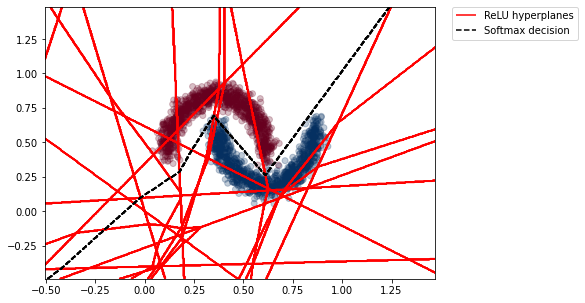

Fit model on training data, n_epochs 150
Epoch 1/150
63/63 [==============================] - 1s 5ms/step - loss: 0.4421 - sparse_categorical_accuracy: 0.9375 - val_loss: 0.2658 - val_sparse_categorical_accuracy: 0.8790
Epoch 2/150
63/63 [==============================] - 0s 3ms/step - loss: 0.2772 - sparse_categorical_accuracy: 0.8680 - val_loss: 0.2865 - val_sparse_categorical_accuracy: 0.8670
Epoch 3/150
63/63 [==============================] - 0s 2ms/step - loss: 0.2813 - sparse_categorical_accuracy: 0.8736 - val_loss: 0.2708 - val_sparse_categorical_accuracy: 0.8745
Epoch 4/150
63/63 [==============================] - 0s 2ms/step - loss: 0.2563 - sparse_categorical_accuracy: 0.8822 - val_loss: 0.2761 - val_sparse_categorical_accuracy: 0.8715
Epoch 5/150
63/63 [==============================] - 0s 2ms/step - loss: 0.2532 - sparse_categorical_accuracy: 0.8827 - val_loss: 0.2542 - val_sparse_categorical_accuracy: 0.8820
Epoch 6/150
63/63 [==============================] - 0s 2ms/step

63/63 [==============================] - 0s 2ms/step - loss: 0.0098 - sparse_categorical_accuracy: 0.9975 - val_loss: 0.0103 - val_sparse_categorical_accuracy: 0.9975
Epoch 47/150
63/63 [==============================] - 0s 3ms/step - loss: 0.0140 - sparse_categorical_accuracy: 0.9969 - val_loss: 0.0089 - val_sparse_categorical_accuracy: 0.9980
Epoch 48/150
63/63 [==============================] - 0s 3ms/step - loss: 0.0141 - sparse_categorical_accuracy: 0.9968 - val_loss: 0.0128 - val_sparse_categorical_accuracy: 0.9955
Epoch 49/150
63/63 [==============================] - 0s 2ms/step - loss: 0.0109 - sparse_categorical_accuracy: 0.9962 - val_loss: 0.0071 - val_sparse_categorical_accuracy: 0.9990
Epoch 50/150
63/63 [==============================] - 0s 2ms/step - loss: 0.0094 - sparse_categorical_accuracy: 0.9968 - val_loss: 0.0097 - val_sparse_categorical_accuracy: 0.9975
Epoch 51/150
63/63 [==============================] - 0s 2ms/step - loss: 0.0171 - sparse_categorical_accuracy: 0

63/63 [==============================] - 0s 3ms/step - loss: 0.0233 - sparse_categorical_accuracy: 0.9882 - val_loss: 0.0251 - val_sparse_categorical_accuracy: 0.9915
Epoch 92/150
63/63 [==============================] - 0s 2ms/step - loss: 0.0064 - sparse_categorical_accuracy: 0.9975 - val_loss: 0.0044 - val_sparse_categorical_accuracy: 0.9985
Epoch 93/150
63/63 [==============================] - 0s 3ms/step - loss: 0.0072 - sparse_categorical_accuracy: 0.9983 - val_loss: 0.0053 - val_sparse_categorical_accuracy: 0.9990
Epoch 94/150
63/63 [==============================] - 0s 2ms/step - loss: 0.0040 - sparse_categorical_accuracy: 0.9995 - val_loss: 0.0076 - val_sparse_categorical_accuracy: 0.9980
Epoch 95/150
63/63 [==============================] - 0s 2ms/step - loss: 0.0088 - sparse_categorical_accuracy: 0.9971 - val_loss: 0.0173 - val_sparse_categorical_accuracy: 0.9945
Epoch 96/150
63/63 [==============================] - 0s 2ms/step - loss: 0.0086 - sparse_categorical_accuracy: 0

63/63 [==============================] - 0s 3ms/step - loss: 0.0205 - sparse_categorical_accuracy: 0.9955 - val_loss: 0.0038 - val_sparse_categorical_accuracy: 0.9990
Epoch 137/150
63/63 [==============================] - 0s 2ms/step - loss: 0.0103 - sparse_categorical_accuracy: 0.9974 - val_loss: 0.0035 - val_sparse_categorical_accuracy: 0.9990
Epoch 138/150
63/63 [==============================] - 0s 2ms/step - loss: 0.0050 - sparse_categorical_accuracy: 0.9977 - val_loss: 0.0058 - val_sparse_categorical_accuracy: 0.9985
Epoch 139/150
63/63 [==============================] - 0s 2ms/step - loss: 0.0039 - sparse_categorical_accuracy: 0.9982 - val_loss: 0.0049 - val_sparse_categorical_accuracy: 0.9990
Epoch 140/150
63/63 [==============================] - 0s 2ms/step - loss: 0.0107 - sparse_categorical_accuracy: 0.9957 - val_loss: 0.0082 - val_sparse_categorical_accuracy: 0.9970
Epoch 141/150
63/63 [==============================] - 0s 2ms/step - loss: 0.0195 - sparse_categorical_accura

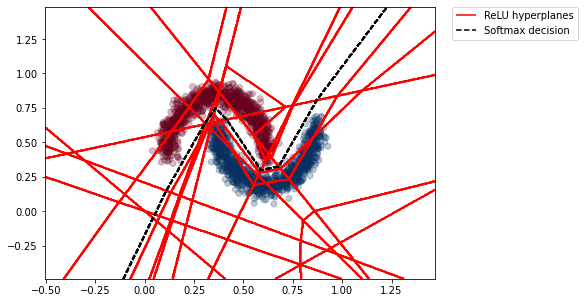

In [142]:
for epochs in [1, 5, 10, 25, 50, 100, 150]:
    print(f"Fit model on training data, n_epochs {epochs}")
    model = tf.keras.models.Sequential([
        CustomConnected(10, tf.eye(10), activations='relu'),
        CustomConnected(10, tf.eye(10), activations='relu'),
        tf.keras.layers.Dense(2, activation='softmax')
    ])
    model.compile(
        optimizer=optimizer,
        loss=loss_fn,
        metrics=[metric],
    )

    history = model.fit(
        X_train,
        y_train,
        batch_size=32,
        epochs=epochs,
        # We pass some validation for
        # monitoring validation loss and metrics
        # at the end of each epoch
        validation_data=(X_test, y_test),
    )
    plot_decision_boundaries(model, X_train, y_train, n_pts=500)

<ipython-input-138-5d72315c9957>:34: UserWarning: No contour levels were found within the data range.
  CS = plt.contour(XX, YY, Z, colors=colors[0], alpha=1)


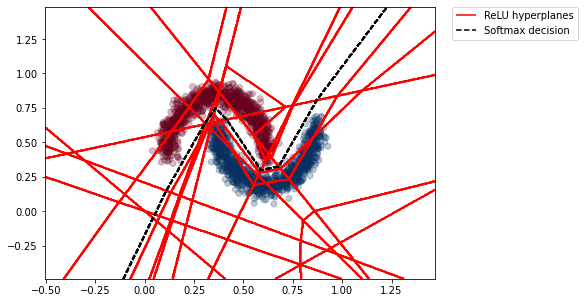

In [143]:
plot_decision_boundaries(model, X_train, y_train, n_pts=500)

## Prune ReLUs

In [148]:
internal_rep = model2internal_rep(model, X_train)

In [149]:
relu_sep = (internal_rep.sum(0) - X_train.shape[0] / 2) / X_train.shape[0]

In [160]:
prune_order = np.argsort(-np.abs(relu_sep))

In [166]:
relu_layers = np.hstack([[i]*model_play.layers[i].units for i in range(len(model_play.layers) - 1)])

Test Accuracy=1.00, n_ReLUs=20


<ipython-input-238-db6b2c4ece2d>:40: UserWarning: No contour levels were found within the data range.
  CS = plt.contour(XX, YY, Z, colors=colors[0], alpha=1)


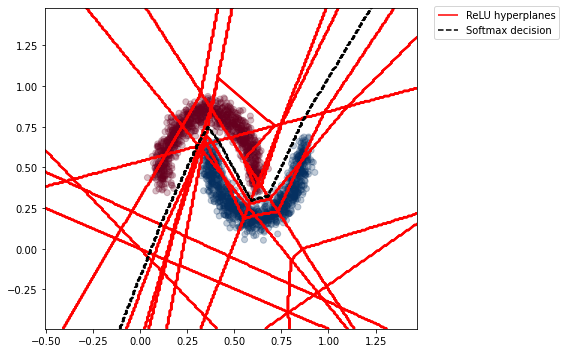

0: layer=0 relu_index=0


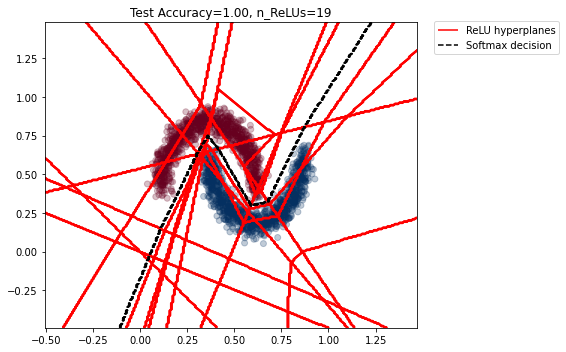

1: layer=1 relu_index=4


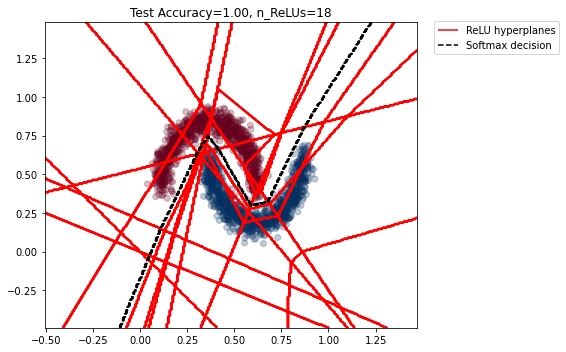

2: layer=1 relu_index=3


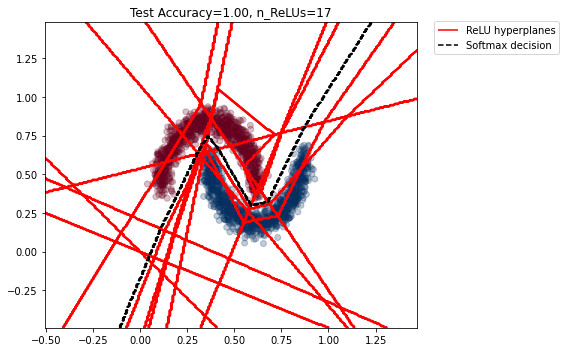

3: layer=1 relu_index=2


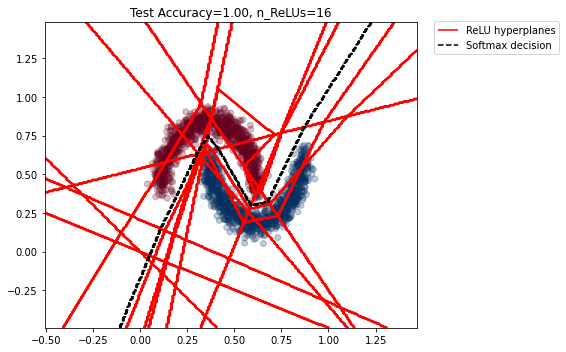

4: layer=1 relu_index=1


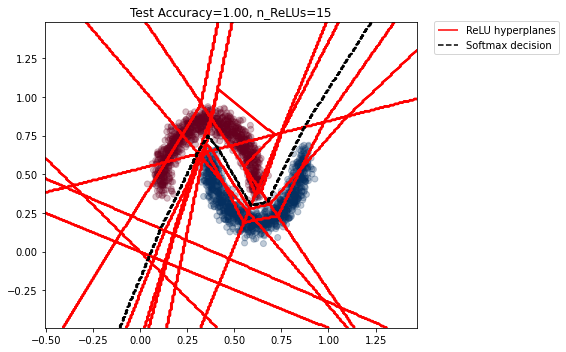

5: layer=1 relu_index=8


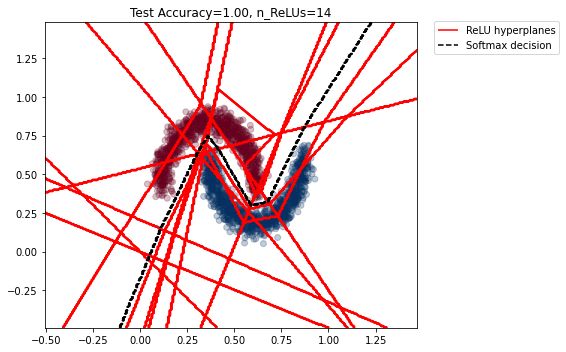

6: layer=0 relu_index=8


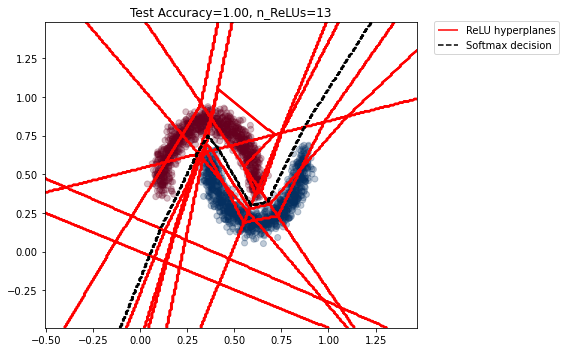

7: layer=1 relu_index=9


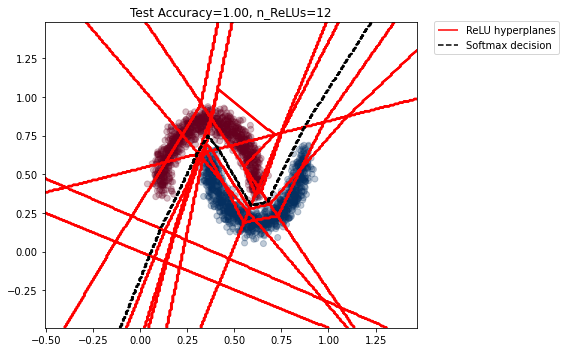

8: layer=0 relu_index=6


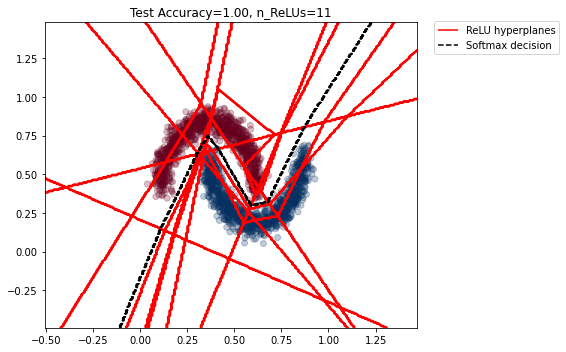

9: layer=0 relu_index=4


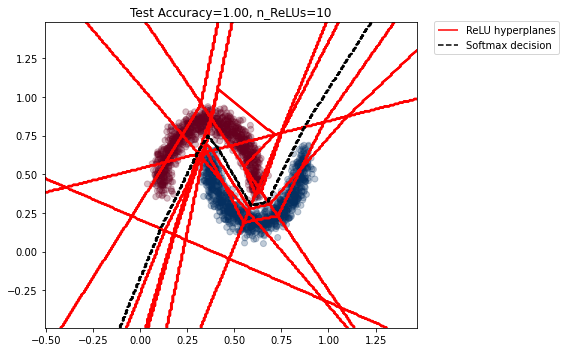

10: layer=0 relu_index=3


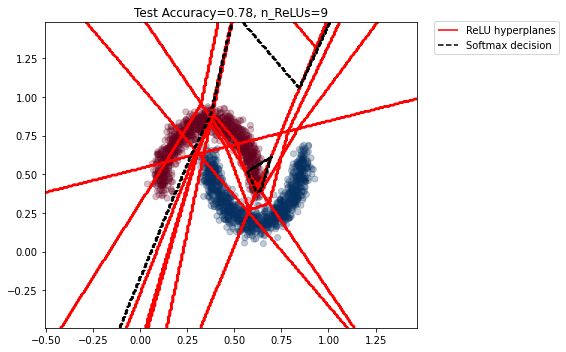

11: layer=1 relu_index=0


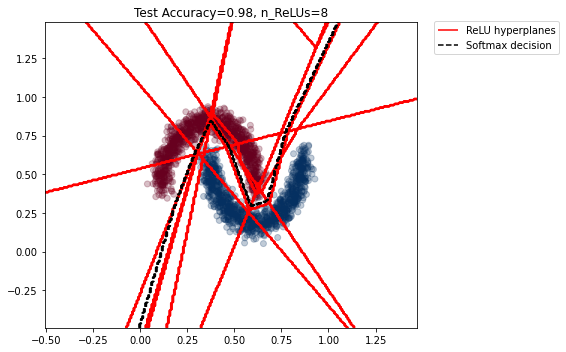

12: layer=0 relu_index=1


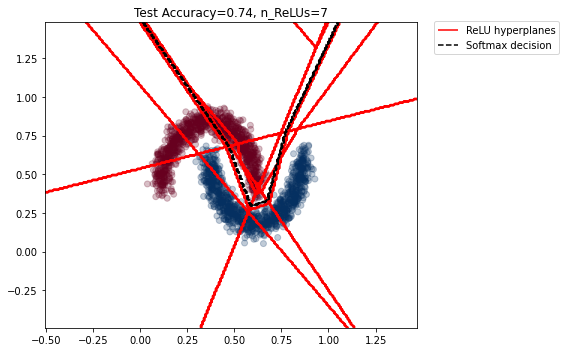

13: layer=0 relu_index=5


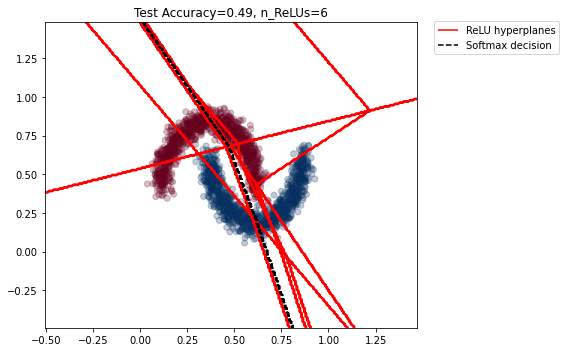

14: layer=1 relu_index=7


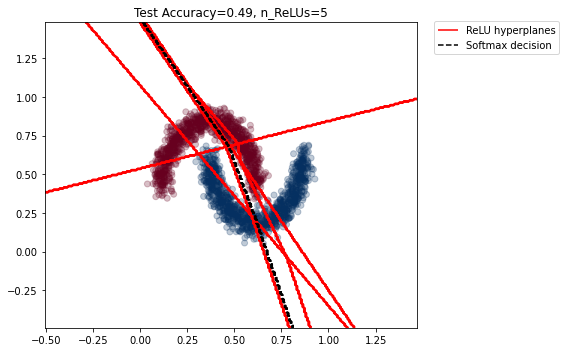

15: layer=0 relu_index=2


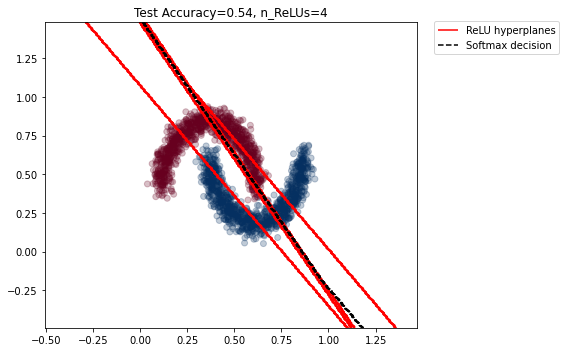

16: layer=1 relu_index=5


<ipython-input-238-db6b2c4ece2d>:45: UserWarning: No contour levels were found within the data range.
  CS = plt.contour(XX, YY, Z_pred, colors='black', alpha=1, linestyles='--')


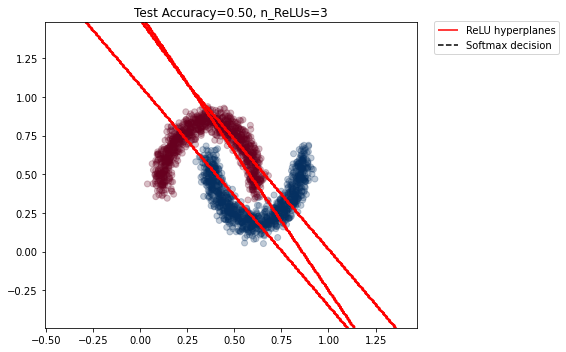

17: layer=0 relu_index=7


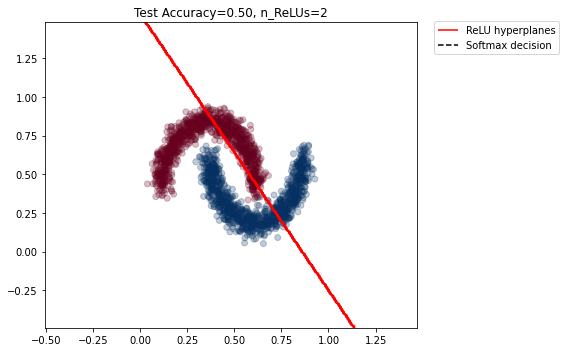

18: layer=0 relu_index=9


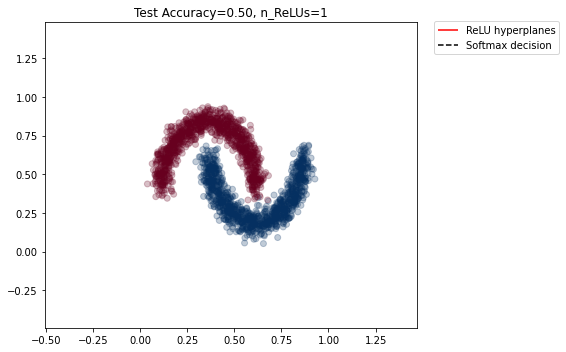

19: layer=1 relu_index=6


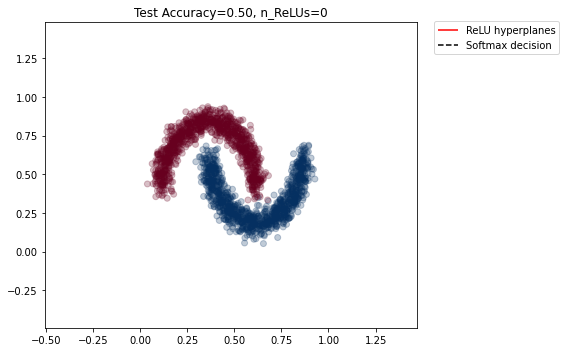

In [239]:
# Reset
for i in range(len(model.layers) - 1):
    for j in range(model.layers[i].units):
        model.layers[i].activations[j] = tf.keras.activations.relu

y_pred = np.argmax(brute_predict(model, X_test), axis=1)
test_accuracy = np.mean(y_pred == y_test)
print(f'Test Accuracy={test_accuracy:.2f}, n_ReLUs={len(prune_order)}')

plot_decision_boundaries(model, X_train, y_train, n_pts=250)

# Plot
for count, idx in enumerate(prune_order):
    if relu_sep[idx] < 0:
        activation = zero_activation
    else:
        activation = zero_activation#tf.keras.activations.linear
    layer_idx = relu_layers[idx]
    relu_in_layer_idx = idx - sum([l.units for l in model.layers[:layer_idx]])
    print(f'{count}:', f'layer={layer_idx}', f'relu_index={relu_in_layer_idx}')
    model.layers[layer_idx].activations[relu_in_layer_idx] = activation

    y_pred = np.argmax(brute_predict(model, X_test), axis=1)
    test_accuracy = np.mean(y_pred == y_test)

    plot_decision_boundaries(
        model, X_train, y_train, n_pts=250,
        title=f'Test Accuracy={test_accuracy:.2f}, n_ReLUs={len(prune_order)-count-1}',
        save_path=f'./results/spiral_layers=2_hyperplanes_relus={len(prune_order)-count-1}.png')

Full model
Test Accuracy=1.00, n_ReLUs=20


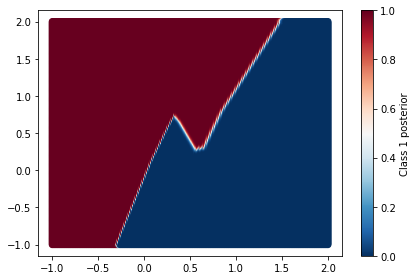

0: layer=0 relu_index=0


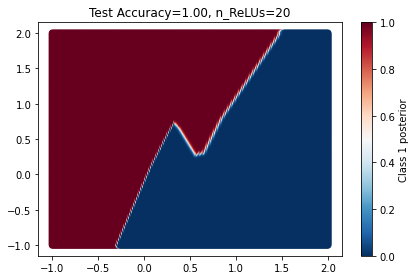

1: layer=1 relu_index=4


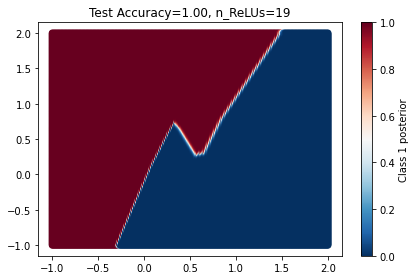

2: layer=1 relu_index=3


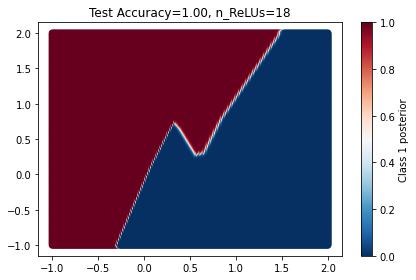

3: layer=1 relu_index=2


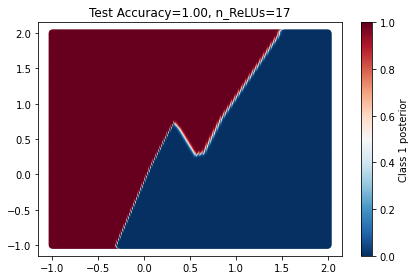

4: layer=1 relu_index=1


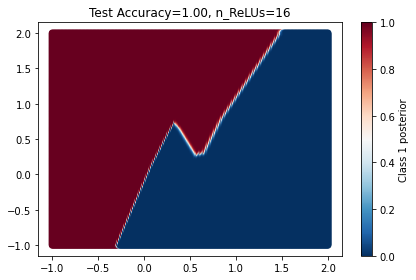

5: layer=1 relu_index=8


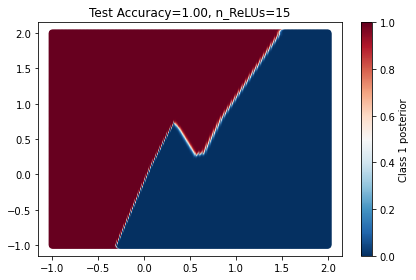

6: layer=0 relu_index=8


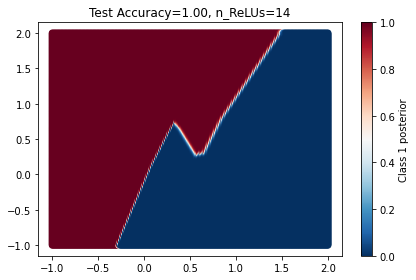

7: layer=1 relu_index=9


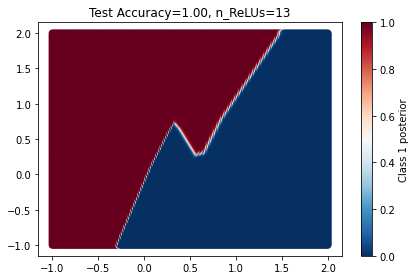

8: layer=0 relu_index=6


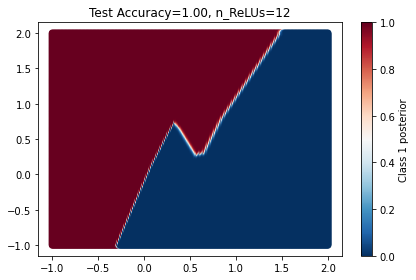

9: layer=0 relu_index=4


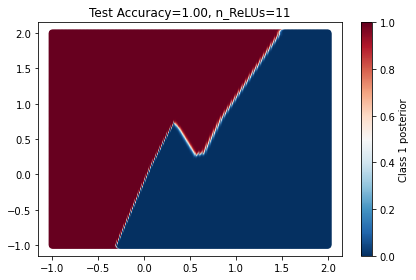

10: layer=0 relu_index=3


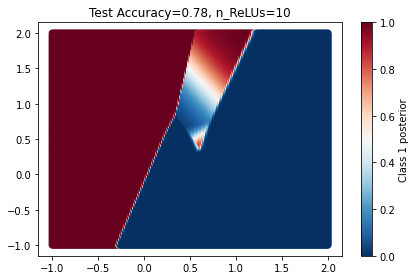

11: layer=1 relu_index=0


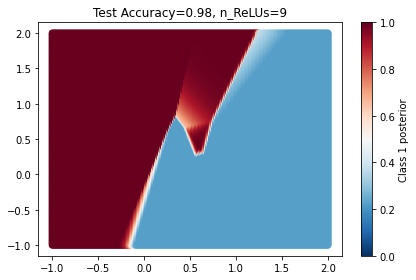

12: layer=0 relu_index=1


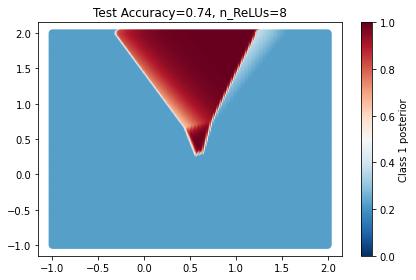

13: layer=0 relu_index=5


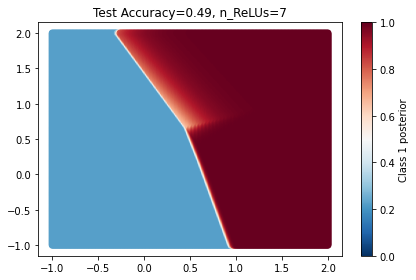

14: layer=1 relu_index=7


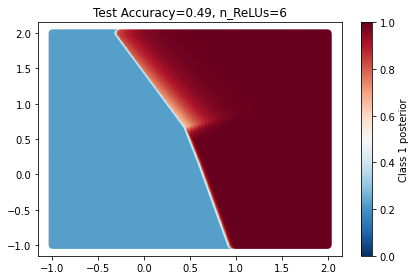

15: layer=0 relu_index=2


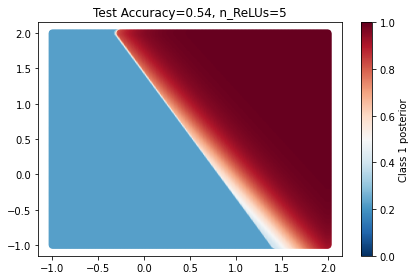

16: layer=1 relu_index=5


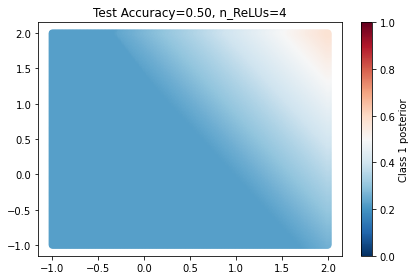

17: layer=0 relu_index=7


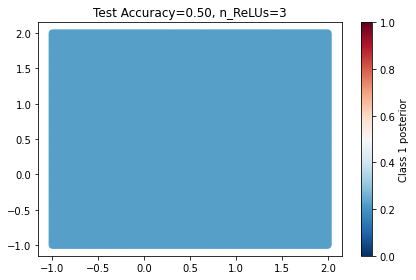

18: layer=0 relu_index=9


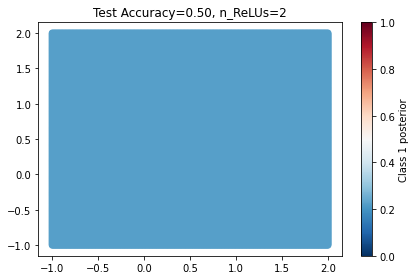

19: layer=1 relu_index=6


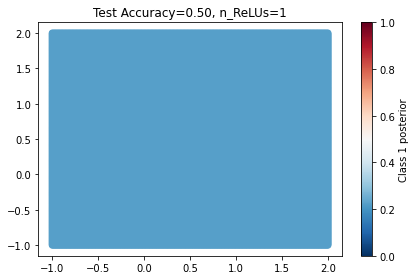

In [237]:
from matplotlib import colors
norm = colors.TwoSlopeNorm(vmin=0, vcenter=0.5, vmax=1)

# Reset
for i in range(len(model.layers) - 1):
    for j in range(model.layers[i].units):
        model.layers[i].activations[j] = tf.keras.activations.relu
print('Full model')
y_pred = np.argmax(brute_predict(model, X_test), axis=1)
test_accuracy = np.mean(y_pred == y_test)
print(f'Test Accuracy={test_accuracy:.2f}, n_ReLUs={len(prune_order)}')
# plot_decision_boundaries(model, X_train, y_train, n_pts=250)
xlim = [-1, 2]
ylim = [-1, 2]
n_pts = 200

xx = np.linspace(xlim[0], xlim[1], n_pts)
yy = np.linspace(ylim[0], ylim[1], n_pts)
YY, XX = np.meshgrid(yy, xx)
XY = np.vstack([XX.ravel(), YY.ravel()]).T

probs = brute_predict(model, XY)

z_plot = probs[:, 0].reshape(XX.shape)

plt.scatter(XY[:, 0], XY[:, 1], c=probs[:, 0], cmap='RdBu_r', norm=norm)
plt.colorbar(label='Class 1 posterior')
plt.tight_layout()
plt.savefig(f'./results/spiral_layers=2_heatmap_relus={len(prune_order)}.png')
plt.show()

# Plot
for count, idx in enumerate(prune_order):
    if relu_sep[idx] < 0:
        activation = zero_activation
    else:
        activation = zero_activation#tf.keras.activations.linear
    layer_idx = relu_layers[idx]
    relu_in_layer_idx = idx - sum([l.units for l in model.layers[:layer_idx]])
    print(f'{count}:', f'layer={layer_idx}', f'relu_index={relu_in_layer_idx}')
    model.layers[layer_idx].activations[relu_in_layer_idx] = activation

    y_pred = np.argmax(brute_predict(model, X_test), axis=1)
    test_accuracy = np.mean(y_pred == y_test)

    # plot_decision_boundaries(model, X_train, y_train, n_pts=250)
    xlim = [-1, 2]
    ylim = [-1, 2]
    n_pts = 200

    xx = np.linspace(xlim[0], xlim[1], n_pts)
    yy = np.linspace(ylim[0], ylim[1], n_pts)
    YY, XX = np.meshgrid(yy, xx)
    XY = np.vstack([XX.ravel(), YY.ravel()]).T

    probs = brute_predict(model, XY)

    z_plot = probs[:, 0].reshape(XX.shape)

    plt.scatter(XY[:, 0], XY[:, 1], c=probs[:, 0], cmap='RdBu_r', norm=norm)
    plt.colorbar(label='Class 1 posterior')
    plt.title((f'Test Accuracy={test_accuracy:.2f}, n_ReLUs={len(prune_order)-count}'))
    plt.tight_layout()
    plt.savefig(f'./results/spiral_layers=2_heatmap_relus={len(prune_order)-count-1}.png')
    plt.show()

In [ ]:
prune_order = np.argsort(-np.abs(relu_sep))

all_relus_

for purity in np.linspace(0.5 + 0.5 / res, 0, res+2):
    results['relu_hyperplane_balance'].append(1 - purity*2)
    
    prune_delete_edge = np.where(model_results['separation_frac'] <= -purity)[0]
    prune_delete_relu = np.where(model_results['separation_frac'] >= purity)[0]
    results['n_relus'].append(n_units - len(prune_delete_edge) - len(prune_delete_relu))
    
    # Prune relus that are always off
    prune_diag = np.ones(n_units).astype('float32')
    prune_diag[prune_delete_edge] = 0
    model.layers[1].connections = tf.constant(tf.linalg.diag(prune_diag))
    
    # Prune relus that are always on
    for idx in (prune_delete_relu):
        model.layers[1].activations[idx] = eye_activation
        
    active_relu_indices = np.setdiff1d(np.arange(n_units), np.concatenate((prune_delete_relu, prune_delete_edge)))
    evalues = evalues_from_regions(model_results['internal_rep'][:, active_relu_indices])
    results['n_activated_regions'].append(sum(evalues > 0))
        
    test_results = eval_model(model, metric, ds_test)
    for key, val in test_results.items():
        results['test_' + key].append(val)
        
    train_results = eval_model(model, metric, ds_train)
    for key, val in train_results.items():
        results['train_' + key].append(val)

In [137]:
xlim = [-1, 2]
ylim = [-1, 2]
n_pts = 200

xx = np.linspace(xlim[0], xlim[1], n_pts)
yy = np.linspace(ylim[0], ylim[1], n_pts)
YY, XX = np.meshgrid(yy, xx)
XY = np.vstack([XX.ravel(), YY.ravel()]).T

probs = model.predict(XY)

z_plot = probs[:, 0].reshape(XX.shape)

plt.scatter(XY[:, 0], XY[:, 1], c=probs[:, 0], cmap='RdBu_r')
plt.show()

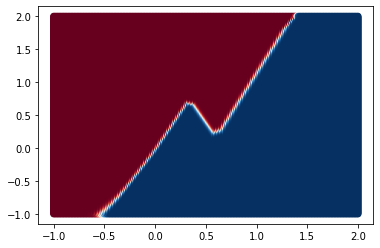

In [79]:
from mpl_toolkits import mplot3d

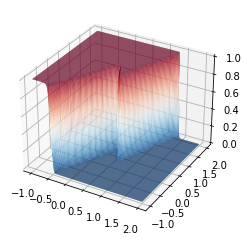

In [80]:
ax = plt.axes(projection='3d')
ax.plot_surface(XX, YY, z_plot, rstride=1, cstride=1,
                cmap='RdBu_r', edgecolor='none')
plt.show()